# Итоговый проект
Распознавание сердечно-сосудистых заболеваний

Импортируем необходимые библиотеки и модули

In [13]:
import pandas as pd
from missingno import matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.models import Sequential
from keras.layers import Dropout, Dense 
from keras.callbacks import EarlyStopping
from keras import regularizers
from kerastuner.tuners import RandomSearch

C:\Users\sagop\AppData\Local\Temp\ipykernel_11100\2626091011.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Получение данных из датасета

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Информация о датасете

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Описательные статистики датасета

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


Преобразуем данные датасета

In [5]:
# Удалим id пациента и целевую переменную из датасета

target_data = df['cardio']
df = df.drop(columns=['id', 'cardio'])

Визуализация пропусков датасета

<Axes: >

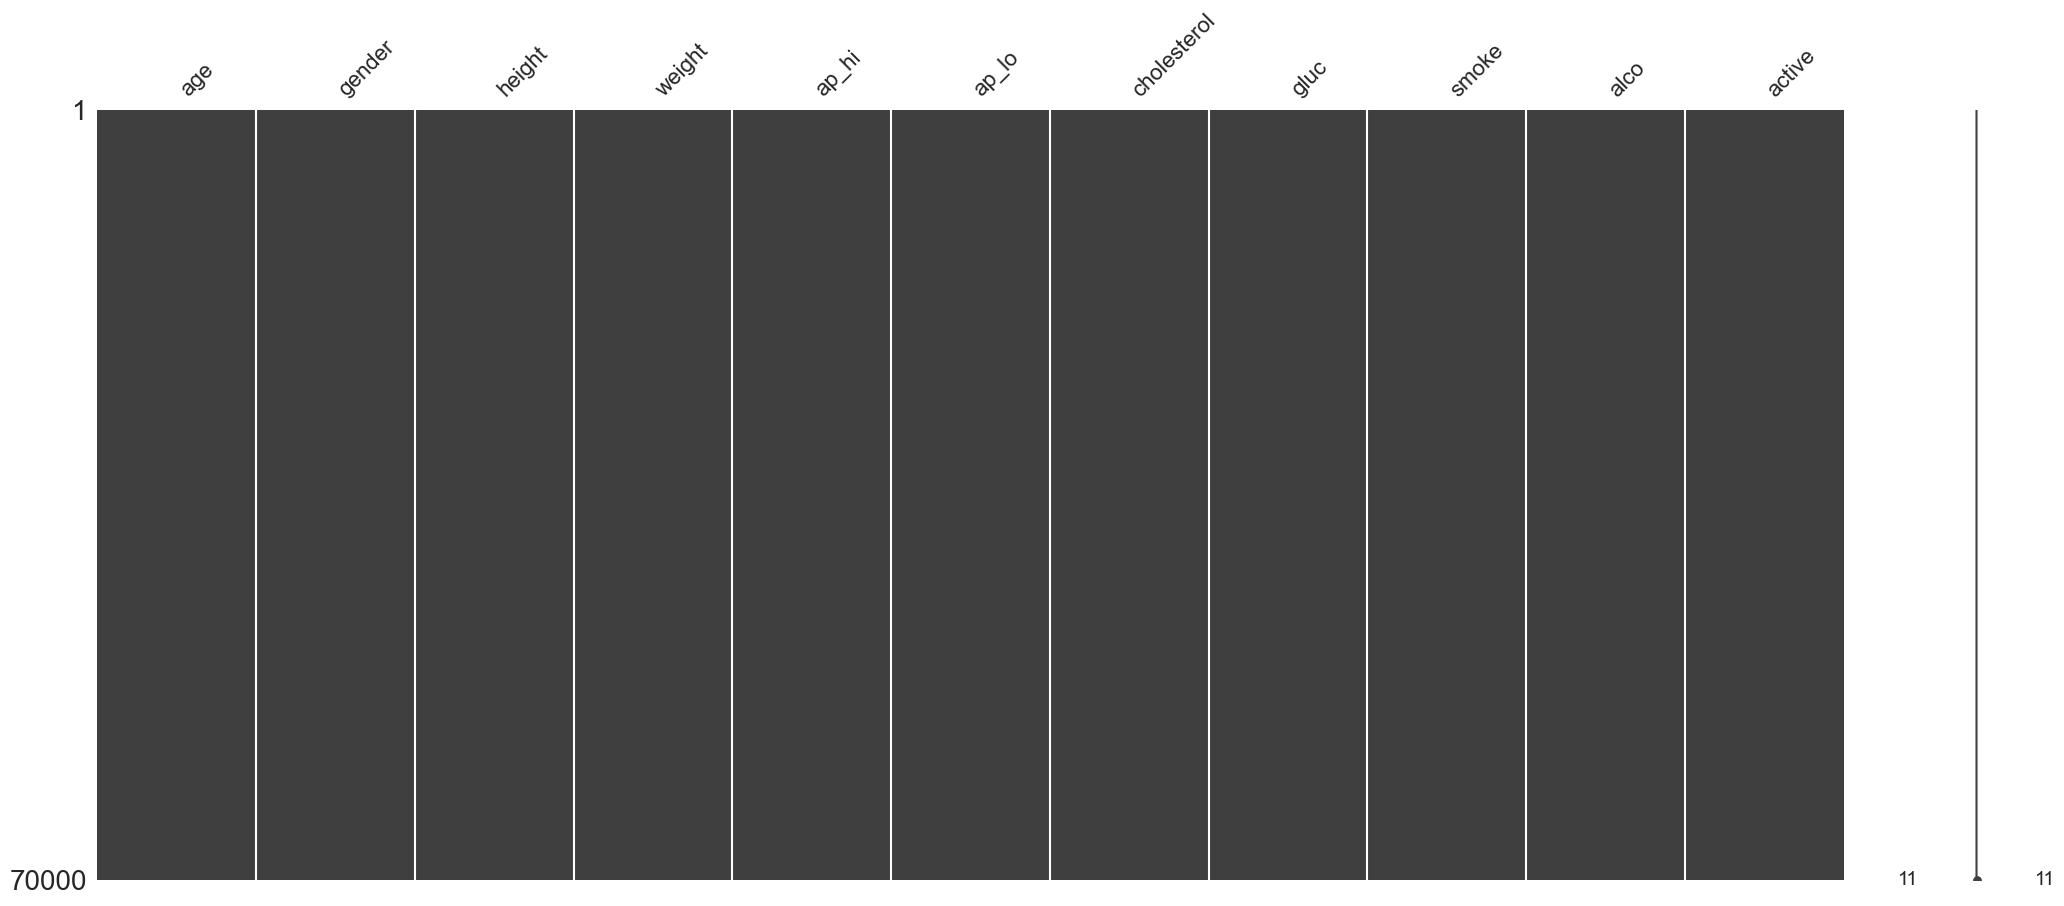

In [6]:
matrix(df)

Избавимся от выбросов с помощью метода межквартильного интервала

In [7]:
binary_columns = df.columns[df.isin([0, 1]).all()]
df_check = df.drop(columns=binary_columns)

Q1 = df_check.quantile(0.25)
Q3 = df_check.quantile(0.75)

df = df.drop(columns=df_check)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

column_to_check = df_check[(df_check >= lower_bound) & (df_check <= upper_bound)]
df = pd.concat([column_to_check, df], axis=1)

Избавимся от пропусков в датасете

In [8]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

imputer = KNNImputer()
df_filled = imputer.fit_transform(df)
df_filled_original = scaler.inverse_transform(df_filled)
df = pd.DataFrame(df_filled_original, columns=df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  float64
 2   height       70000 non-null  float64
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  float64
 5   ap_lo        70000 non-null  float64
 6   cholesterol  70000 non-null  float64
 7   gluc         70000 non-null  float64
 8   smoke        70000 non-null  float64
 9   alco         70000 non-null  float64
 10  active       70000 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


Выполним нормализацию и стандартизацию данных

In [9]:
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

normalized_data = minmax_scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

standard_data = standard_scaler.fit_transform(df)
df = pd.DataFrame(standard_data, columns=df.columns)

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.436398,1.364055,0.470154,-0.905920,-1.062436,-0.251989,-0.539322,0.0,-0.310879,-0.238384,0.494167
1,0.307602,-0.733108,-1.105485,0.953922,0.889390,1.029498,2.400793,0.0,-0.310879,-0.238384,0.494167
2,-0.248270,-0.733108,0.076244,-0.744195,0.238781,-1.533476,2.400793,0.0,-0.310879,-0.238384,-2.023607
3,-0.748595,1.364055,0.601457,0.711334,1.539999,2.310984,-0.539322,0.0,-0.310879,-0.238384,0.494167
4,-0.809007,-0.733108,-1.105485,-1.391096,-1.713045,-1.097770,-0.539322,0.0,-0.310879,-0.238384,-2.023607


Подготовка данных для обучения

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, target_data, test_size=0.3)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Первая модель нейронной сети

In [11]:
first_model = Sequential()
first_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
first_model.add(Dropout(0.1))
first_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
first_model.add(Dropout(0.1))
first_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
first_model.add(Dropout(0.1))
first_model.add(Dense(2, activation='softmax'))

first_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = first_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])
first_model.summary()

test_loss, test_accuracy = first_model.evaluate(X_test, y_test)
print("Accuracy:", test_accuracy)

Epoch 1/100
1532/1532 [==============================] - 18s 9ms/step - loss: 0.7006 - accuracy: 0.7213 - val_loss: 0.5708 - val_accuracy: 0.7277
Epoch 2/100
1532/1532 [==============================] - 14s 9ms/step - loss: 0.5770 - accuracy: 0.7264 - val_loss: 0.5653 - val_accuracy: 0.7301
Epoch 3/100
1532/1532 [==============================] - 13s 9ms/step - loss: 0.5734 - accuracy: 0.7255 - val_loss: 0.5651 - val_accuracy: 0.7324
Epoch 4/100
1532/1532 [==============================] - 12s 8ms/step - loss: 0.5726 - accuracy: 0.7272 - val_loss: 0.5697 - val_accuracy: 0.7301
Epoch 5/100
1532/1532 [==============================] - 14s 9ms/step - loss: 0.5729 - accuracy: 0.7255 - val_loss: 0.5633 - val_accuracy: 0.7308
Epoch 6/100
1532/1532 [==============================] - 12s 8ms/step - loss: 0.5712 - accuracy: 0.7252 - val_loss: 0.5628 - val_accuracy: 0.7283
Epoch 7/100
1532/1532 [==============================] - 13s 8ms/step - loss: 0.5702 - accuracy: 0.7255 - val_loss: 0.5633 -

Вторая модель нейронной сети

In [12]:
second_model = Sequential()
second_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), input_shape=(X_train.shape[1],)))
second_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
second_model.add(Dense(256, activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
second_model.add(Dropout(0.2))
second_model.add(Dense(256, activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
second_model.add(Dropout(0.2))
second_model.add(Dense(256, activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
second_model.add(Dropout(0.2))
second_model.add(Dense(256, activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
second_model.add(Dropout(0.2))
second_model.add(Dense(256, activation='tanh', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
second_model.add(Dropout(0.2))
second_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
second_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
second_model.add(Dense(2, activation='softmax'))

second_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
second_history = first_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
second_model.summary()

_, test_accuracy = second_model.evaluate(X_test, y_test)
print("Accuracy:", test_accuracy)

Epoch 1/100
1532/1532 [==============================] - 22s 14ms/step - loss: 0.5710 - accuracy: 0.7253 - val_loss: 0.5637 - val_accuracy: 0.7308
Epoch 2/100
1532/1532 [==============================] - 9s 6ms/step - loss: 0.5696 - accuracy: 0.7253 - val_loss: 0.5622 - val_accuracy: 0.7309
Epoch 3/100
1532/1532 [==============================] - 15s 10ms/step - loss: 0.5699 - accuracy: 0.7270 - val_loss: 0.5621 - val_accuracy: 0.7298
Epoch 4/100
1532/1532 [==============================] - 17s 11ms/step - loss: 0.5691 - accuracy: 0.7261 - val_loss: 0.5590 - val_accuracy: 0.7316
Epoch 5/100
1532/1532 [==============================] - 23s 15ms/step - loss: 0.5693 - accuracy: 0.7251 - val_loss: 0.5597 - val_accuracy: 0.7323
Epoch 6/100
1532/1532 [==============================] - 13s 9ms/step - loss: 0.5689 - accuracy: 0.7250 - val_loss: 0.5604 - val_accuracy: 0.7287
Epoch 7/100
1532/1532 [==============================] - 12s 8ms/step - loss: 0.5687 - accuracy: 0.7248 - val_loss: 0.558

Третья модель нейронной сети

In [15]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32), 
                    activation='relu', 
                    kernel_regularizer=regularizers.l2(hp.Choice('l2_input', values=[0.01, 0.001, 0.0001]))))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                        activation='relu',
                        kernel_regularizer=regularizers.l2(hp.Choice(f'l2_{i}', values=[0.01, 0.001, 0.0001]))))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.build(X_train.shape)  
best_model.summary()

_, test_accuracy = best_model.evaluate(X_test, y_test)
print("Accuracy:", test_accuracy)

Reloading Tuner from .\untitled_project\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (49000, 192)              2304      
                                                                 
 dropout (Dropout)           (49000, 192)              0         
                                                                 
 dense_1 (Dense)             (49000, 256)              49408     
                                                                 
 dropout_1 (Dropout)         (49000, 256)              0         
                                                                 
 dense_2 (Dense)             (49000, 2)                514       
                                                                 
Total params: 52226 (204.01 KB)
Trainable params: 52226 (204.01 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________